# Neural event detection

### A simple example based on an example timeseries generated by Kaidi

Author: Ali Zaidi

Date 20.08.2019

In [1]:
from __future__ import print_function, absolute_import

In [2]:
from scipy.signal import stft
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
%matplotlib notebook

In [4]:
fname = "./data/Time_Series_N2_long.mat"
data = sio.loadmat(fname)

In [5]:
Vp = data['Vp']

In [6]:
f, t, data_stft = stft(Vp, fs=1000, nperseg=1024, noverlap=128, axis=1)
data_stft = np.abs(np.squeeze(data_stft)) # Required for normalization

In [7]:
dsm = np.mean(data_stft, axis=1)
dsm_r = np.repeat(dsm[:, np.newaxis], data_stft.shape[1], axis=1)

dsd = np.std(data_stft, axis=1)
dsd_r = np.repeat(dsd[:, np.newaxis], data_stft.shape[1], axis=1)

data_stft_norm = (data_stft - dsm_r) / dsd_r

<IPython.core.display.Javascript object>


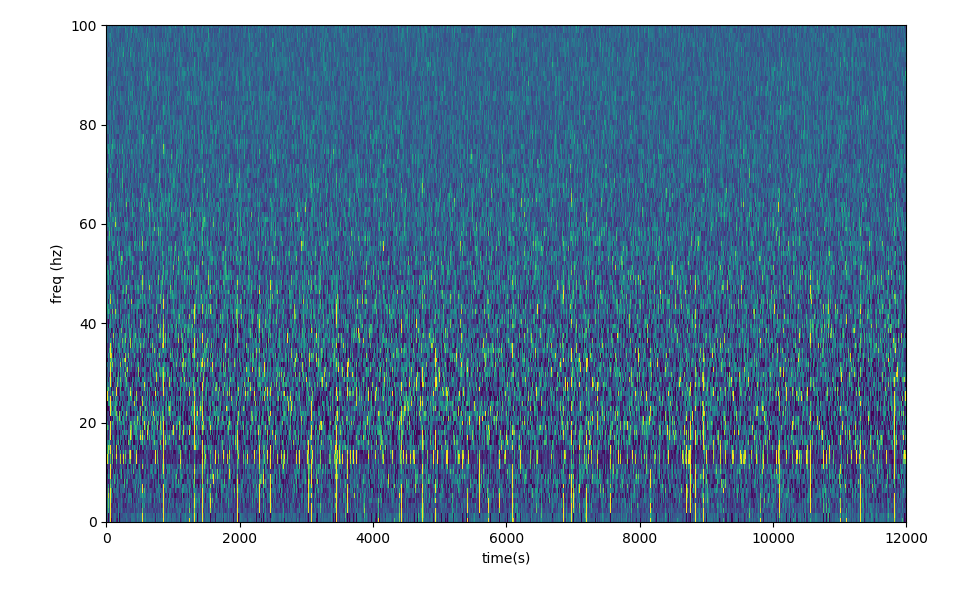

In [13]:
plt.pcolormesh(t, f, data_stft_norm)
plt.clim([-1, 2])
plt.ylim([0, 100])
plt.xlabel('time(s)')
plt.ylabel('freq (hz)')
plt.tight_layout()

In [33]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN().fit(data_stft_norm[:100,:].T)
labels = clustering.labels_
print(np.unique(labels))

[-1]


### Using simple manifold approximation to reduce the dimensionality of the dataset

In [25]:
from umap import UMAP
embedding = UMAP().fit_transform(data_stft_norm[:100,:].T)

c:\users\azaidi.000\appdata\local\continuum\anaconda3\envs\pytorch\lib\site-packages\numba\compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\appdata\local\continuum\anaconda3\envs\pytorch\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


<IPython.core.display.Javascript object>


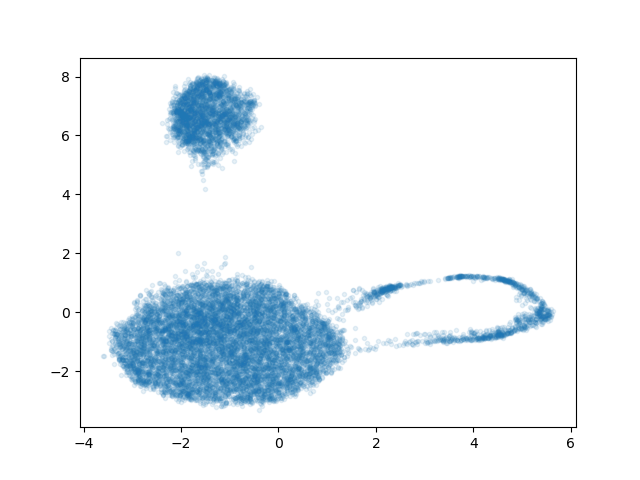

In [29]:
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], marker='.', alpha=0.1)

In [30]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN().fit(embedding)
labels = clustering.labels_

<IPython.core.display.Javascript object>


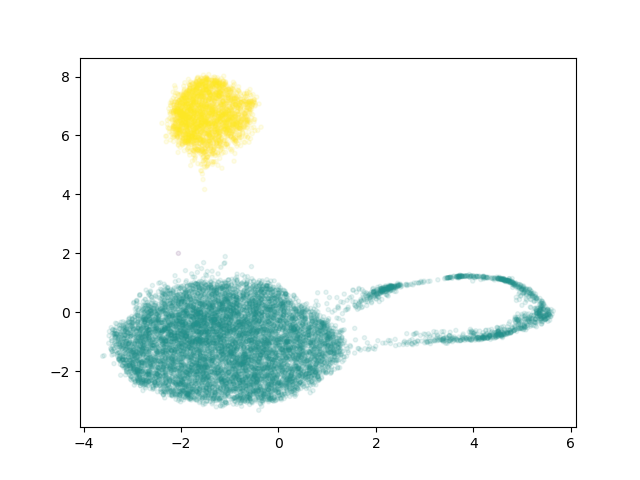

In [31]:
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], marker='.', alpha=0.1, c=labels)